# Generic Object Detection
We will be mainly utilising the watershed algorithm to do object detection on plain background.

Code developed from https://www.udemy.com/course/python-for-computer-vision-with-opencv-and-deep-learning/

## Other models considered
- YOLOv7 CLIP: This does not work as the pre-trained data does not include screws and thus initial tests shows that the model does not pick up on the screw objects.
- CounTR: This does not work as well as the pre-trained data does not include screws. Moreover even when testing the model against data it was pre-trained on, the result was unsatisfactory (eg. 2.jpg from FSC147 dataset)

## Business Requirement
- Detection should be able to pick up objects without any training as there could be thousands of different variety of objects to be detected

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
%matplotlib inline

In [2]:
def img_read_resize(source, max_width = "default", color = 'rgb'):
    # display in rgb
    if color == 'rgb':
        color = cv2.IMREAD_COLOR
        img = cv2.imread(source, color)
        org_height, org_width, _ = img.shape
    # display in grayscale
    else:
        color = cv2.IMREAD_GRAYSCALE
        img = cv2.imread(source, color)
        org_height, org_width = img.shape
    
    if max_width == "default":
        return img
    else:
        # scale picture according to max width specified
        scale_ratio = org_width/max_width
        scaled_height = int(org_height/scale_ratio)
        img = cv2.resize(img, (max_width, scaled_height), interpolation = cv2.INTER_AREA)
        return img

In [3]:
def img_display(img, cmap=None):
    # fig = plt.figure()
    # ax = fig.add_subplot()
    # ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img,cmap=cmap)

In [16]:
def crop_background(img, threshold_type = "otsu",  threshold_manual_val = 160, threshold_adaptive_val = 10, filter_diameter = 33, kernel_size = 3, crop_percent = 2.5):
    
    # We want to crop out the background and only leave the white paper as the border of the image
    # we blur the image first so that the unnecessary details doesn't show up
    # we use bilateralFilter instead of other methods (such as medianblur, gaussianblur) as it gives us the sharpest of the white paper edges
    # while also removing those unnecesary details from the background
    blurred_img = cv2.bilateralFilter(img,filter_diameter,75,75)
    # we follow up with a open morphing to remove any unwanted small white dots on a black background. 
    # so that our image before finding contours is cleaner
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    blurred_img = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
    
    # change image to grayscale so that we can split it up by intensity of graycolor
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)

    # set threshold to filter out those colors that are not white (we define white as below 140 value)
    # then for those that is above the threshold, we change it to black (255)
    # the part that you want to detect should be white. 
    if threshold_type == "Otsu":
        ret, thres_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    elif threshold_type == "Adaptive":
        thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, threshold_adaptive_val)
    elif threshold_type == "Manual":
        ret, thres_img = cv2.threshold(gray_img, threshold_manual_val, 255, cv2.THRESH_BINARY)

    # img_display(thres_img)


    # DESKEW image based on url below
    # https://stackoverflow.com/questions/59660933/how-to-de-skew-a-text-image-and-retrieve-the-new-bounding-box-of-that-image-pyth/59672620#59672620
    def determine_score(arr, angle):
        data = rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    scores = []
    angles = np.arange(-5, 5 + 1, 1)
    for angle in angles:
        histogram, score = determine_score(thres_img, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = thres_img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected_img = cv2.warpAffine(thres_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # contours: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    # cv2.RETR_EXTERNAL will return all the external contours
    # cv2.CHAIN_APPROX_SIMPLE will only return 4 points instead of detailed pixel by pixel points 
    contours, hierarchy  = cv2.findContours(corrected_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort the contours to get the biggest contour (just in case we get more than 1 contour)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # to crop the image based on the contour
    # we pass in contours[0] because there's only 1 contour is our case
    x, y, w, h = cv2.boundingRect(contours[0])


    # we crop off abit more to compensate for the skewness of the picture
    org_height, org_width = corrected_img.shape
    cut_pixels = int(org_width*crop_percent/100)
    cropped_img = img[y+cut_pixels:y+h-cut_pixels, x+cut_pixels:x+w-cut_pixels]
   
    return cropped_img

In [227]:
def object_count(img, blur_kernel_size = 33, erode_kernel_size = 0, erode_iteration = 0, dilate_kernel_size = 0, dilate_iteration = 0, open_kernel_size = 0, open_iteration = 0, close_kernel_size = 0, close_iteration = 0):
    # blur the image using gaussianblur
    # we don't use bilateral because we only want to detect the center of the object, bilateral highlights too much edges
    blurred_img = cv2.GaussianBlur(img,(blur_kernel_size,blur_kernel_size),0)

    # change image to grayscale so that we can split it up by intensity of graycolor
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)

    # instead of using normal threshold where we set the threshold manually, we use adaptive threshold because the light intensity varies across the picture
    # https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/
    # 21 is the grid in which we search for optimum threshold (21 by 21)
    # 10 is our finetune threshold related to the ADAPTIVE_THRESH_MEAN_C
    # we don't use adaptive threshold because we want the threshold to be singular instead of adaptive across the image. so that the output would be clean
    # thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    thres_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)

    target_img = thres_img.copy()
    # img_display(target_img, 'gray')
    # erode reduce the edges of brighter white pixels
    target_img = cv2.erode(target_img, np.ones((erode_kernel_size, erode_kernel_size), np.uint8), iterations=erode_iteration)
    # img_display(target_img, 'gray')
    # dilate grow the edges of brighter white pixels
    target_img = cv2.dilate(target_img, np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8), iterations=dilate_iteration)
    # img_display(target_img, 'gray')
    # Closing. It is obtained by the dilation of an image followed by an erosion.
    target_img = cv2.morphologyEx(target_img, op = cv2.MORPH_CLOSE, kernel = np.ones((close_kernel_size, close_kernel_size), np.uint8), iterations=close_iteration)
    # Opening. It is obtained by the erosion of an image followed by a dilation.
    target_img = cv2.morphologyEx(target_img, op = cv2.MORPH_OPEN, kernel = np.ones((open_kernel_size, open_kernel_size), np.uint8), iterations=open_iteration)
    # img_display(target_img, 'gray')
    target_img = target_img.astype(np.uint8)

    # Get the pixels which we are sure that is the background
    sure_bg = cv2.dilate(target_img, np.ones((3, 3), np.uint8), iterations=3)
    # img_display(sure_bg, 'gray')

    # Perform distance transformation. pixels that are further away from the background would be given higher white intensity
    # thereby increasing our confidence that those intense white are the foreground (our object of interest)
    # https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
    distance_transformed_out = cv2.distanceTransform(target_img, cv2.DIST_L2, 5)
    # img_display(distance_transformed_out)

    # do another threshold function to gather the pixels which we are sure is the foregroud after distanceTransform
    ret, sure_fg = cv2.threshold(distance_transformed_out.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_display(sure_fg)
    # get the unknown area
    unknown = cv2.subtract(sure_bg, sure_fg)

    # img_display(unknown, 'gray')

    # connectedComponents help us to treat each markers as individual components
    # https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # we add 1 to markers to differentiate the eventual background from the unknown pixel which we equates to 0 in the next line
    markers = markers+1
    markers[unknown==255] = 0

    # perform watershed
    # https://pyimagesearch.com/2015/11/02/watershed-opencv/
    # we have to perform watershed on a color image
    markers = cv2.watershed(blurred_img, markers)

    # return number of unique objects
    counter = 0
    for marker in np.unique(markers):
        # -1 refers to the outline
        # 1 refers to the background
        # all other numbers means different classes
        if marker == -1 or marker == 1:
            continue
        counter += 1

    return markers, counter

In [275]:
def display_contours(cropped_image, markers, contour_percentile = 0.3, contour_thres = 2):
    final_image = cropped_image.copy()
    # loop over the unique labels returned by the Watershed algorithm
    contour_dict = {'contours':[], 'areas':[], 'colors':[]}
    for marker in np.unique(markers):
        # if the marker is one, we are examining the 'background'
        # if the marker is -1, we are looking at the outline
        # so simply ignore it
        if marker == 1 or marker == -1:
            continue
        # otherwise, allocate create a mask just for the particular marker region
        mask = np.zeros(markers.shape, dtype="uint8")
        # for every marker (ie, -1, 2, 3, 4, 5, 6), change it to 255 each time.
        # now we will only have mask that has 1 marker each time
        mask[markers == marker] = 255
        # detect contours in the mask and grab the largest one
        contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        # random color
        color = list(np.random.random(size=3) * 256)

        contour_dict['contours'].append(contours[0])
        contour_dict['areas'].append(cv2.contourArea(contours[0]))
        contour_dict['colors'].append(color)


    # Final check to ensure that our detected contours is between the average area of the 30th and 70th percentile of all the contours found.
    # if the detected contour is bigger than this average area or lesser than this average area by 30%, then ignore it
    def percentile_avg(percentile, target_list):
        if len(target_list) == 0:
            return 0
        target_list.sort()
        percentile_int = int(round(percentile*len(target_list)))
        average = sum(target_list[percentile_int:-percentile_int])/len(target_list[percentile_int:-percentile_int])
        return average
    
    counter = 0
    avg_3070 = percentile_avg(contour_percentile, contour_dict['areas'])
    for i in range(len(contour_dict['contours'])):
        if avg_3070 / contour_thres <= contour_dict['areas'][i] <= avg_3070 * contour_thres:
            final_image = cv2.drawContours(final_image, [contour_dict['contours'][i]], -1, contour_dict['colors'][i], 2)
            counter += 1
    
    return final_image, counter

5 object(s) detected


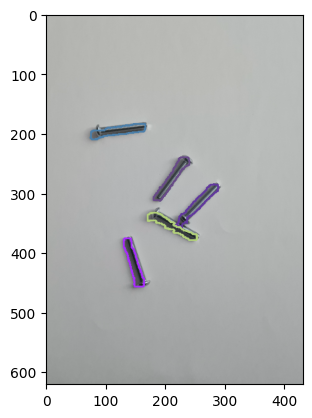

In [280]:
org_img = img_read_resize("input.jpg", max_width= 640)
cropped_img = crop_background(org_img, threshold_type = "Otsu", threshold_adaptive_val=10, filter_diameter = 23, kernel_size = 5, crop_percent = 5)
markers, counter = object_count(cropped_img,erode_kernel_size = 0, erode_iteration = 0, dilate_kernel_size = 0, dilate_iteration = 0, open_kernel_size = 3, open_iteration = 1, close_kernel_size = 3, close_iteration = 0)
final_img, counter = display_contours(cropped_img, markers)

img_display(final_img)

print(f"{counter} object(s) detected")

# Limitations
- Due to no training done, when objects are overlayed such as in screw2.jpg, the detection would not be accurate
- Lighting conditions plays a big role in detecting the number of objects due to the range of pixels on the same object across different area of the object